In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from iminuit import Minuit
import pandas as pd
import scipy.interpolate as interpolate
from scipy.integrate import quad
from matplotlib import colors

We first define some functions that will be used

In [2]:
def chisq(obs, exp, error):
    return np.sum(np.square(obs - exp) / np.square(error))

In [3]:
def Gauss(E, A, mu, sigma):
    return A * (np.exp(-1/2 * np.square((E - mu) / sigma)) / (sigma * np.sqrt(2*np.pi)))

def Gauss_int(A, mu, sigma, Em, Ep):
    return quad(Gauss, Em, Ep, args=(A, mu, sigma))

Now we define the Multiple broken power law

In [4]:
def multiple_bpl(xdata, params):
    if knots < 2 or knots > 30: #change this when adding more number of knots
        raise Exception('knots have to be larger or equal than 3 and smaller than 30')
    else:
        polw = np.zeros(len(xdata))
        Ebr = np.geomspace(xdata[0], xdata[-1], knots+2)[1:-1]
        gamma = np.zeros(knots+1)
        phi = np.zeros(knots+1)
        phi_0 = params[0] #len(sqrtdelta_lam) = len(lam)-1 = len(phi)-1
        gamma0 = params[1]
        sqrtdelta_gamma = params[2:knots+2]
        delta_gamma = np.square(sqrtdelta_gamma)
        gamma[0] = gamma0
        phi[0] = phi_0
        for i in range(knots):
            gamma[i+1] = gamma[i] + delta_gamma[i]
            phi[i+1] = phi[i] * Ebr[i] ** delta_gamma[i]
        for i in range(len(xdata)):
            for j in range(knots):
                if xdata[i]<Ebr[0]:
                    polw[i] = phi[0] * xdata[i] ** (-gamma[0])
                elif Ebr[-1] < xdata[i]:
                    polw[i] = phi[-1] * xdata[i] ** (-gamma[-1])
                elif Ebr[j] <= xdata[i] < Ebr[j+1]:
                    polw[i] = phi[j+1] * xdata[i] ** (-gamma[j+1])
    return polw
    # else:
    #     polw = np.zeros(len(xdata))
    #     Es = np.geomspace(xdata[0], xdata[-1], knots)
    #     lam = np.zeros(knots-1)
    #     phi = np.zeros(knots-1)
    #     phi_0 = params[0] #len(sqrtdelta_lam) = len(lam)-1 = len(phi)-1
    #     lam0 = params[1]
    #     sqrtdelta_lam = params[2:knots]
    #     lam[0] = lam0
    #     phi[0] = phi_0 * ((1/Es[1]) ** (-lam[0]))
    #     for i in range(1, knots-1):
    #         lam[i] = lam[i-1] + ((sqrtdelta_lam[i-1]) ** 2)
    #         phi[i] = phi[i-1] * ((1/Es[i]) ** (-(sqrtdelta_lam[i-1]) ** 2))
    #     for i in range(knots-1):
    #         for j in range(len(xdata)):
    #             if Es[i] < xdata[j] <= Es[i+1]:
    #                 polw[j] = phi[i] * ((xdata[j]) ** (-lam[i]))
    #             elif xdata[j] <= Es[1]:
    #                 polw[j] = phi[0] * ((xdata[j]) ** (-lam[0]))
    #             elif xdata[j] > Es[-1]:
    #                 polw[j] = phi[-2] * ((xdata[j]) ** (-lam[-2]))
    # return polw


The least squares function for that MBPWL

In [5]:
# least-squares score function = sum of data residuals squared
def LSQ(params):
    return np.sum((ydata - multiple_bpl(xdata, params)) ** 2 / ydata_u ** 2)

And the fit function

In [6]:
def multiple_bpl_fit(initial_guess):
    #print('Warning: the shape of the parametes will depend on the number of knots (defined as knots)')
    #print('Warning: this will give the parameters of the fit and its errors which have to be put into the multiple_bpl function in order to get the fit')
    LSQ.errordef = Minuit.LIKELIHOOD

    m = Minuit(LSQ, initial_guess)
    #m.limits["initial_guess[2:-1]"] = (0,None)
    m.tol = 1e-20

    m.migrad()
    print(m.values)

    m.hesse()
    print(m.errors)

    return m

Here we will load the Effective area of the telescope and the EBL model file. After that we will also load background rate.

In [7]:
fileEA = np.loadtxt('EffArea50h.txt', skiprows = 11)
EffA = pd.DataFrame(fileEA)
EffA = EffA.rename(columns={ 0 : 'E [TeV]', 1: 'Eff area (m^2)'})
EffaE= EffA['E [TeV]'].to_numpy()
Effa = EffA['Eff area (m^2)'].to_numpy()

#absorption file
file = np.loadtxt('tau_dominguez11.out')
pdfile = pd.DataFrame(file)
pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105'})
E = pdfile['E [TeV]'].to_numpy()
tau = pdfile['tau z=0.20842105'].to_numpy()

For the background rate we need to do a rebinning to have the same energy bins as with the other data.

In [8]:
fileBkg = np.loadtxt('Bkg50h.txt', skiprows = 10)
Bkgpd = pd.DataFrame(fileBkg)
Bkgpd = Bkgpd.rename(columns={ 0 : 'E_min (TeV)', 1: 'E_max (TeV)', 2: 'Bck Rate (Hz/deg^2)'})

BckgEmin = Bkgpd['E_min (TeV)'].to_numpy()
BckgEmax = Bkgpd['E_max (TeV)'].to_numpy()
Bckg = Bkgpd['Bck Rate (Hz/deg^2)'].to_numpy()
BckgEdiff = BckgEmax - BckgEmin

BckgElogmean = []
for i in range(len(Bckg)):
    BckgElogmean.append(10**(np.mean([np.log10(BckgEmax[i]), np.log10(BckgEmin[i])])))


Ebinsmin = np.zeros(len(E))
Ebinsmax = np.zeros(len(E))

for i in range(1, len(E)):
    Ebinsmin[i] = 10**(np.mean([np.log10(E[i]), np.log10(E[i-1])]))
for i in range(len(E) - 1):
    Ebinsmax[i] = 10**(np.mean([np.log10(E[i]), np.log10(E[i+1])]))
    
Ebinsmin[0] = 10**(np.log10(Ebinsmin[1])-(np.log10(Ebinsmin[2])-np.log10(Ebinsmin[1])))
Ebinsmax[len(E)-1] = 10**(np.log10(Ebinsmax[len(E)-2])-(np.log10(Ebinsmax[len(E)-3])-np.log10(Ebinsmax[len(E)-2])))
Ebinsw = Ebinsmax - Ebinsmin

In [9]:
DifBckg = Bckg / (BckgEmax - BckgEmin) #Hz/deg**2
def log_interp1d(xx, yy):
    logx = np.log10(xx)
    logy = np.log10(yy)
    interp = interpolate.interp1d(logx, logy, fill_value='extrapolate', kind='slinear')
    log_interp = lambda zz: np.power(10.0, interp(np.log10(zz)))
    return log_interp

interpolation = log_interp1d(BckgElogmean,DifBckg)

In [10]:
newBckgrate = np.zeros([len(E[2:37]),2])
for i in range(len(E[2:37])):
    newBckgrate[i] = quad(interpolation, Ebinsmin[i+2], Ebinsmax[i+2])
newBckgrate = newBckgrate[:,0]

After that we create the spectrum of the source and we absorve it with the EBL model loaded before. If you want to change the source spectra, change it here.

In [11]:
#“photon index  = 2.03  +/- 0.03 and normalization factor at 250 GeV    f0 = (8.70 +/- 0.17) * 10^-10 cm^-2  s^-1  TeV^-1.”
K =  8.70e-6 #m−2  s−1  TeV−1
dNdE = K / ((E/0.25)**2.03) 
m_tau = -tau
dNdEa = dNdE * np.exp(m_tau)

We also need to do a rebinning of the effective area

In [12]:
EffaA2 = np.zeros(len(E[2:37]))
for i in range(len(E[2:37])):
    for j in range(len(EffaE[9:51])):
        if EffaE[j+9] < E[i+2] and EffaE[j+10] > E[i+2]:
            m = (Effa[j+10]-Effa[j+9])/(EffaE[j+10]-EffaE[j+9])
            n = Effa[j+9] - m * EffaE[j+9]
            EffaA2[i] = m * E[i+2] + n

And we will also need the angular resolution of the telescope which, of course, will need to be rebinned.

In [13]:
fileAng = np.loadtxt('Angres.txt', skiprows = 11)
Angresall = pd.DataFrame(fileAng)
Angresall = Angresall.rename(columns={ 0 : 'E [TeV]', 1: 'Angular resolution (deg)'})
AngresE= Angresall['E [TeV]'].to_numpy()
Angres = Angresall['Angular resolution (deg)'].to_numpy()

logAngres = np.log10(Angres)
logAngresE = np.log10(AngresE)
logE = np.log10(E)


logAngres2 = np.zeros(len(E[2:37]))
for i in range(len(E[2:37])):
    for j in range(len(AngresE[1:-1])):
        if logAngresE[j+1] < logE[i+2] and logAngresE[j+2] > logE[i+2]:
            m = (logAngres[j+2]-logAngres[j+1])/(logAngresE[j+2]-logAngresE[j+1])
            n = logAngres[j+1] - m * logAngresE[j+1]
            logAngres2[i] = m * logE[i+2] + n
Angres2 = 10**logAngres2

We use all that and we define the time of observation and we have the poisson parameter of the background.

In [14]:
def degtorad(ang):
    return ang * np.pi / 180


time = 42480 #42480 #180000#s
skyang = (180/np.pi)**2 * 2 * np.pi * (1-np.cos(degtorad(Angres2)))#deg^2

bckgmu = newBckgrate * time * skyang

Let's load the Energy resolution and rebin it to fit our data. After that we will get the poisson parameter of the source taking into account the energy resolution.

In [15]:
fileEres = np.loadtxt('Eres.txt', skiprows = 8)
Eresall = pd.DataFrame(fileEres)
Eresall = Eresall.rename(columns={ 0 : 'E [TeV]', 1: 'Energy resolution (deg)'})
EresE = Eresall['E [TeV]'].to_numpy()
Eres = Eresall['Energy resolution (deg)'].to_numpy()

logEres = np.log10(Eres)
logEresE = np.log10(EresE)
logE = np.log10(E)


logEres2 = np.zeros(len(E[2:37]))
for i in range(len(E[2:37])):
    for j in range(len(EresE[0:-1])):
        if logEresE[j] < logE[i+3] and logEresE[j+1] > logE[i+3]:
            m = (logEres[j+1]-logEres[j])/(logEresE[j+1]-logEresE[j])
            n = logEres[j] - m * logEresE[j]
            logEres2[i] = m * logE[i+3] + n
Eres2 = 10**logEres2
Eres3 = Eres2 * E[2:37]


logEbins = np.zeros(len(E[2:37])+1)
for i in range(len(E[2:37])+1):
    if i == 0:
        logEbins[i] = logE[2] - ((logE[3]-logE[2])/2)
    elif i == (len(E[2:37])):
        logEbins[i] = logE[2:37][i-1] + ((logE[2:37][i-1]-logE[2:37][i-2])/2)
    else:
        logEbins[i] = (logE[2:37][i] + logE[2:37][i-1]) / 2

Ebins = 10 ** logEbins

mu_vec = dNdEa[2:37] * EffaA2 * Ebinsw[2:37] * time

mu_vec_reco = np.zeros(len(mu_vec))
mu_vec_i = np.zeros(len(mu_vec))

for i in range(len(mu_vec)):
    for j in range(len(mu_vec)):
        A = mu_vec[i]
        B = bckgmu[i]
        Em = Ebins[j]
        Ep = Ebins[j+1]
        sigma = Eres3[i]
        mu = E[2:37][i]

        mu_vec_i[j] = Gauss_int(A, mu, sigma, Em, Ep)[0]
    mu_vec_reco = mu_vec_reco + mu_vec_i

We finally run our simulation. First we generate 2 random samples of the background. The first one is the background contribution to the observations and the other one is the observed background in 5 wobbles that we will use to reduce the background noise. After that we also simulate the source spectra. Those 3 things are made using a Poisson disteibution. Then we sum the 3 contributions and we take the number of photons to SED. Finally we use this SED and deabsorb the EBL while fitting the MBPWL to every value of $\alpha$ and get its corresponding $\chi^2$ value.

In [21]:
niter = 100  #number of iterations (1000 iterations take ~38 min)
chisqs_iter = []
alphas_iter = []

for j in range(niter):
    my_generator = np.random.default_rng(j)
    Simbckg1 = my_generator.poisson(bckgmu)
    # Simbckg1 = Simbckg1.astype(float)
    # for i in range(len(Simbckg1)):
    #     if Simbckg1[i] == 0:
    #         Simbckg1[i] = bckgmu[i]
    Simbckg1_u = np.sqrt(Simbckg1)
    Simbckg5 = my_generator.poisson(5*bckgmu)/5
    # Simbckg5 = Simbckg5.astype(float)
    # for i in range(len(Simbckg5)):
    #     if Simbckg5[i] == 0:
    #         Simbckg5[i] = bckgmu[i]
    Simbckg5_u = np.sqrt(Simbckg5)

    N = my_generator.poisson(mu_vec_reco)

    for i in range(len(N)): #this is used to avoid crashing when dividing by 0.
        if N[i] == 0:
            N[i] = 1
    N_u = np.sqrt(N)

    NpB = np.around(N + Simbckg1 - Simbckg5).astype(int)
    NpB_u = N_u + Simbckg1_u - Simbckg5_u

    dNdE_b = NpB[1:] / EffaA2[1:35] / Ebinsw[3:37] / time
    dNdE_b_u = NpB_u[1:] / EffaA2[1:35] / Ebinsw[3:37] / time

    SED = np.square(E[3:37]) * dNdE_b
    SED_u = np.square(E[3:37]) * dNdE_b_u

    chisqs = []
    alphas = np.arange(0,2.05,0.05) #if you want to change the alpha values

    for i in range(len(alphas)):
        alpha = alphas[i]
        print("alpha = ", alpha)
        dNdE2 = dNdE_b[4:] * np.exp(alpha*tau[7:37])
        dNdE2_u = dNdE_b_u[4:] * np.exp(alpha*tau[7:37])
        SED2 = np.square(E[7:37]) * dNdE2
        SED_u2 = np.square(E[7:37]) * dNdE2_u
        ydata = SED2
        xdata = E[7:37]
        knots = 3
        ydata_u = SED_u2
        initial_guess = np.array([5e-7, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots))
        things = multiple_bpl_fit(initial_guess=initial_guess)
        chi2 = chisq(SED2, multiple_bpl(E[7:37], things.values), SED_u2)
        chisqs.append(chi2)
        # if alpha == 0.6000000000000001:# or alpha == 0.15 or alpha == 0.9 or alpha == 1.:
        #     plt.plot(xdata, multiple_bpl(xdata, things.values), label='concave fit', color = 'orange')
        #     plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
        #     plt.xscale('log')
        #     plt.yscale('log')
        #     plt.xlabel(r"$E$ ($TeV$)")
        #     plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
        #     plt.legend()
        #     plt.show() 

    alphas_iter.append(alphas)
    chisqs_iter.append(chisqs)
    print("\033[2;31;43m iteration {iter} of {niter} finished \033[0;0m".format(iter = j+1, niter = niter))

alpha =  0.0
<ValueView x0=3.259481876252788e-07 x1=0.21162509297915685 x2=-1.0971206841728285 x3=0.0 x4=0.0>
<ErrorView x0=8.419694388998598e-09 x1=0.012968364695061477 x2=0.009556613727812361 x3=1.4144631726408328 x4=0.061655248610076985>
alpha =  0.05
<ValueView x0=3.341416365595494e-07 x1=0.20211365280629923 x2=-1.0695642199499478 x3=0.0 x4=0.0>
<ErrorView x0=8.648208952166674e-09 x1=0.012991913874839948 x2=0.009837843846856053 x3=1.4144554114015986 x4=0.06316168441758699>
alpha =  0.1
<ValueView x0=3.186593174573751e-07 x1=0.22499533841641797 x2=-0.9613953504741282 x3=0.63219034099312 x4=6.320708441335525e-07>
<ErrorView x0=9.150544003446758e-09 x1=0.014203645821226574 x2=0.015653087346737413 x3=0.04353279378334415 x4=0.37304231078693295>
alpha =  0.15000000000000002
<ValueView x0=3.445636738525595e-07 x1=0.19158660354865117 x2=-0.9953385367473275 x3=0.0 x4=-0.7476601627884574>
<ErrorView x0=9.169547503346912e-09 x1=0.013319223392875959 x2=0.011214518294797998 x3=1.414471457382402

/tmp/ipykernel_22186/293466026.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((ydata - multiple_bpl(xdata, params)) ** 2 / ydata_u ** 2)
/tmp/ipykernel_22186/293466026.py:3: RuntimeWarning: overflow encountered in true_divide
  return np.sum((ydata - multiple_bpl(xdata, params)) ** 2 / ydata_u ** 2)



<ErrorView x0=9.194161147419683e-09 x1=0.007663972401807573 x2=0.03854079793174736 x3=0.06557483241325332 x4=0.1689810080846901>
alpha =  1.2000000000000002
<ValueView x0=7.060900174378352e-07 x1=-0.11553240433713534 x2=0.0 x3=0.0 x4=0.0>
<ErrorView x0=1.0177014138286205e-08 x1=0.007866788396006626 x2=0.03443358820849744 x3=0.057929758821812435 x4=0.1541231972186936>
alpha =  1.25
<ValueView x0=7.614972026074001e-07 x1=-0.14988763871376543 x2=0.0 x3=0.0 x4=0.0>
<ErrorView x0=1.1242956030728234e-08 x1=0.00807331595863971 x2=0.03160588435811948 x3=0.0531993129237682 x4=0.1451196532244781>
alpha =  1.3
<ValueView x0=8.195971220632567e-07 x1=-0.18325619948093566 x2=0.0 x3=0.0 x4=0.0>
<ErrorView x0=1.2394887812268245e-08 x1=0.008282690085407333 x2=0.029536574299202884 x3=0.05006094281936124 x4=0.13956127701949117>
alpha =  1.35
<ValueView x0=8.803552113873431e-07 x1=-0.21563066767527714 x2=0.0 x3=0.0 x4=0.0>
<ErrorView x0=1.3635197996190375e-08 x1=0.008493982410723546 x2=0.0279607328586209

/tmp/ipykernel_22186/59404806.py:25: RuntimeWarning: overflow encountered in double_scalars
  polw[i] = phi[j+1] * xdata[i] ** (-gamma[j+1])
/tmp/ipykernel_22186/59404806.py:25: RuntimeWarning: invalid value encountered in double_scalars
  polw[i] = phi[j+1] * xdata[i] ** (-gamma[j+1])



<ValueView x0=4.682295008069633e-07 x1=0.07523278079318713 x2=-0.3623359829459258 x3=0.2770380061974722 x4=-0.4555285199976287>
<ErrorView x0=1.3586683657079401e-08 x1=0.01428012511908654 x2=0.04389053298050918 x3=0.12041201423132507 x4=0.20499682936729718>
alpha =  0.9
<ValueView x0=4.813830819181152e-07 x1=0.06444380248714879 x2=-0.2846390402918443 x3=0.2247577417045386 x4=-0.49071924663384703>
<ErrorView x0=1.3968530472301632e-08 x1=0.014278562820609996 x2=0.055920253369832744 x3=0.14812042331292122 x4=0.1911221602554638>
alpha =  0.9500000000000001
<ValueView x0=4.948957013898171e-07 x1=0.05366331869062385 x2=-0.17542554524988294 x3=0.15584208165308083 x4=-0.5237329830672223>
<ErrorView x0=1.4387140846524268e-08 x1=0.014303274048956368 x2=0.09102454142921923 x3=0.21392617719856383 x4=0.18018179954176713>
alpha =  1.0
<ValueView x0=5.185050991993499e-07 x1=0.03374292909345139 x2=0.0 x3=2.4175636614236704e-06 x4=-0.513508403137783>
<ErrorView x0=7.0272503037524116e-09 x1=0.007327324

/tmp/ipykernel_22186/59404806.py:17: RuntimeWarning: overflow encountered in double_scalars
  phi[i+1] = phi[i] * Ebr[i] ** delta_gamma[i]
/tmp/ipykernel_22186/59404806.py:23: RuntimeWarning: invalid value encountered in double_scalars
  polw[i] = phi[-1] * xdata[i] ** (-gamma[-1])



<ErrorView x0=1.1701313330735523e-08 x1=0.014124800212218713 x2=0.025242003201106436 x3=0.12118645333975946 x4=0.1554430036021999>
alpha =  0.65
<ValueView x0=4.1978337410042515e-07 x1=0.11162206641425891 x2=-0.5736618254233558 x3=0.21991733462231552 x4=-0.6109543523283952>
<ErrorView x0=1.2051594454076525e-08 x1=0.014145742508127676 x2=0.027198705485154483 x3=0.15136014044530902 x4=0.1487066132112235>
alpha =  0.7000000000000001
<ValueView x0=4.3161720344178545e-07 x1=0.10079956608395238 x2=-0.5277692086760166 x3=0.1459463959518843 x4=-0.639161855781367>
<ErrorView x0=1.2413046395727071e-08 x1=0.014167667833252857 x2=0.029667669898456737 x3=0.22821695390998298 x4=0.14295358142447803>
alpha =  0.75
<ValueView x0=4.4343001824762236e-07 x1=0.09033213547322395 x2=-0.4757040514093146 x3=7.067555316994386e-07 x4=0.6587291930458816>
<ErrorView x0=1.2108407924699202e-08 x1=0.01358234117947279 x2=0.025436176389749262 x3=0.6185055418107419 x4=0.10722769256132403>
alpha =  0.8
<ValueView x0=4.5

/tmp/ipykernel_22186/59404806.py:17: RuntimeWarning: invalid value encountered in double_scalars
  phi[i+1] = phi[i] * Ebr[i] ** delta_gamma[i]



<ErrorView x0=1.3897196816670947e-08 x1=0.014488433525568318 x2=0.030317213021279266 x3=1.2016045504682937 x4=0.1344721898861158>
alpha =  0.8
<ValueView x0=4.838783517484821e-07 x1=0.059877869871914055 x2=-0.48985629250928986 x3=1.66760708773566e-07 x4=-0.6898209992080361>
<ErrorView x0=1.331598282093766e-08 x1=0.013711689927001388 x2=0.02497774188276878 x3=0.28994590747847343 x4=0.10373012334941642>
alpha =  0.8500000000000001
<ValueView x0=4.956069520969337e-07 x1=0.050765982192278056 x2=-0.4262112033754024 x3=8.582421176997406e-08 x4=-0.6773794149241922>
<ErrorView x0=1.3664288892133375e-08 x1=0.013732771876252627 x2=0.028838887456394745 x3=0.20353136179172499 x4=0.10579474943008503>
alpha =  0.9
<ValueView x0=5.075979556840557e-07 x1=0.04167271909638894 x2=-0.3512981334305143 x3=-1.4222051365788887e-07 x4=-0.6645026155501934>
<ErrorView x0=1.4035378000408097e-08 x1=0.013767768670716461 x2=0.035178123422787824 x3=0.16596582659294137 x4=0.10801279620404831>
alpha =  0.9500000000000

/tmp/ipykernel_22186/59404806.py:21: RuntimeWarning: overflow encountered in double_scalars
  polw[i] = phi[0] * xdata[i] ** (-gamma[0])


<ValueView x0=4.410481750646764e-07 x1=0.11041361610839684 x2=-0.31913260657740405 x3=-0.4846695864750419 x4=-0.3235476119752993>
<ErrorView x0=1.2597943306920772e-08 x1=0.014075619884848891 x2=0.04872929638671466 x3=0.06847592006091023 x4=0.32236822342215754>
alpha =  0.8500000000000001
<ValueView x0=4.5338122845081445e-07 x1=0.09968754574322748 x2=-0.22613311995692023 x3=-0.457543080609495 x4=-0.376201676941216>
<ErrorView x0=1.2972231285643766e-08 x1=0.014097685125373944 x2=0.06892379760560874 x3=0.0724124377783467 x4=0.2789632551643371>
alpha =  0.9
<ValueView x0=4.6604752433852163e-07 x1=0.0889717318724942 x2=-0.021091019542610712 x3=-0.42870668974386605 x4=-0.4226850603053005>
<ErrorView x0=1.3290011428706988e-08 x1=0.01405342831155949 x2=0.7361784867081936 x3=0.07695598329230213 x4=0.2497874438192266>
alpha =  0.9500000000000001
<ValueView x0=4.978904687788785e-07 x1=0.059940048751203845 x2=3.5347720756823385e-07 x3=-0.304166387807777 x4=-0.5262667078027675>
<ErrorView x0=7.7543

And we plot the result of that.

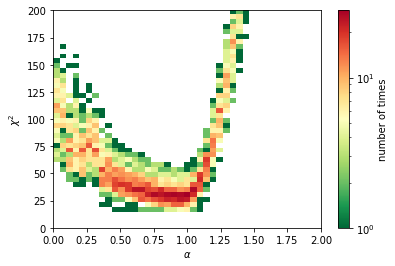

In [24]:
alphas_iter2 = np.concatenate(alphas_iter)  #As the simulation takes long, the plot is made separately so one can change the plot without having to simulate everything again
chisqs_iter2 = np.concatenate(chisqs_iter)


fig, ax = plt.subplots()
h = ax.hist2d(alphas_iter2, chisqs_iter2, bins=[41,300], norm = colors.LogNorm(), cmap = "RdYlGn_r")
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\chi^2$')
ax.set_ylim(0,200)
fig.colorbar(h[3], ax=ax, label="number of times")

After that, if needed we can do the same again with more $\alpha$ values between 0.76 and 1.14

In [18]:
niter = 10
chisqs_iter = []
alphas_iter = []

for j in range(niter):
    my_generator = np.random.default_rng(j)
    Simbckg1 = my_generator.poisson(bckgmu)
    # Simbckg1 = Simbckg1.astype(float)
    # for i in range(len(Simbckg1)):
    #     if Simbckg1[i] == 0:
    #         Simbckg1[i] = bckgmu[i]
    Simbckg1_u = np.sqrt(Simbckg1)
    Simbckg5 = my_generator.poisson(5*bckgmu)/5
    # Simbckg5 = Simbckg5.astype(float)
    # for i in range(len(Simbckg5)):
    #     if Simbckg5[i] == 0:
    #         Simbckg5[i] = bckgmu[i]
    Simbckg5_u = np.sqrt(Simbckg5)

    N = my_generator.poisson(mu_vec_reco)

    # for i in range(len(N)):
    #     if N[i] == 0:
    #         N[i] = mu[i]
    N_u = np.sqrt(N)

    NpB = np.around(N + Simbckg1 - Simbckg5).astype(int)
    NpB_u = N_u + Simbckg1_u - Simbckg5_u

    dNdE_b = NpB[1:] / EffaA2[1:35] / Ebinsw[3:37] / time
    dNdE_b_u = NpB_u[1:] / EffaA2[1:35] / Ebinsw[3:37] / time

    SED = np.square(E[3:37]) * dNdE_b
    SED_u = np.square(E[3:37]) * dNdE_b_u

    chisqs = []
    alphas = np.arange(0.76,1.14,0.02)

    for i in range(19):
        alpha = alphas[i]
        print("alpha = ", alpha)
        dNdE2 = dNdE_b[4:] * np.exp(alpha*tau[7:37])
        dNdE2_u = dNdE_b_u[4:] * np.exp(alpha*tau[7:37])
        SED2 = np.square(E[7:37]) * dNdE2
        SED_u2 = np.square(E[7:37]) * dNdE2_u
        ydata = SED2
        xdata = E[7:37]
        knots = 5
        ydata_u = SED_u2
        initial_guess = np.array([5e-7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots-2))
        things = multiple_bpl_fit(initial_guess=initial_guess)
        chi2 = chisq(SED2, multiple_bpl(E[7:37], things.values), SED_u2)
        chisqs.append(chi2)
    alphas_iter.append(alphas)
    chisqs_iter.append(chisqs)
    print("\033[2;31;43m iteration {iter} of {niter} finished \033[0;0m".format(iter = j+1, niter = niter))


alpha =  0.76
<ValueView x0=4.6120301654506137e-07 x1=0.08103797583238162 x2=-0.2810532338213382 x3=-0.4867190718483385 x4=-1.3595260213495592e-07 x5=-1.1475791267291913e-07 x6=-1.0183502630662125 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
alpha =  0.78
<ValueView x0=4.647543956545758e-07 x1=0.07819979076210042 x2=-0.2642063412983198 x3=-0.466778977015604 x4=-2.787469462835191e-07 x5=2.3277079733735837e-07 x6=-1.0234716956850216 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
alpha =  0.8
<ValueView x0=4.6833225980587503e-07 x1=0.0753623933384665 x2=-0.24620647149239078 x3=-0.4459542416339615 x4=-1.122563671982472e-08 x5=-8.918676601067938e-08 x6=-1.028582280221845 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
alpha =  0.8200000000000001
<ValueView x0=4.7193726398812

/tmp/ipykernel_22186/59404806.py:21: RuntimeWarning: overflow encountered in double_scalars
  polw[i] = phi[0] * xdata[i] ** (-gamma[0])
/tmp/ipykernel_22186/59404806.py:25: RuntimeWarning: overflow encountered in double_scalars
  polw[i] = phi[j+1] * xdata[i] ** (-gamma[j+1])
/tmp/ipykernel_22186/59404806.py:25: RuntimeWarning: invalid value encountered in double_scalars
  polw[i] = phi[j+1] * xdata[i] ** (-gamma[j+1])



<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
alpha =  1.0000000000000002
<ValueView x0=5.133971439330906e-07 x1=0.029611875542618266 x2=0.0 x3=0.0 x4=-2.0128579623750954e-07 x5=-0.22435221884815026 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
alpha =  1.0200000000000002
<ValueView x0=5.291469538319265e-07 x1=0.016055588345771196 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
alpha =  1.0400000000000003
<ValueView x0=5.470695974594831e-07 x1=0.0008440685351577406 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
alpha =  1.0600000000000003
<ValueView x0=5.654240002443667e-07 x1=-0.014223802930152315 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0

And plot it again

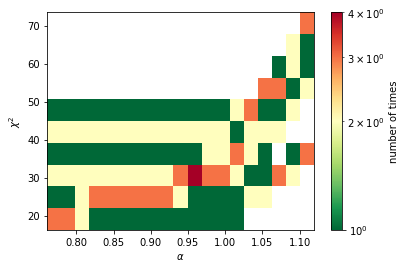

In [19]:
alphas_iter2 = np.concatenate(alphas_iter)
chisqs_iter2 = np.concatenate(chisqs_iter)


fig, ax = plt.subplots()
h = ax.hist2d(alphas_iter2, chisqs_iter2, bins=[19,10], norm = colors.LogNorm(), cmap = "RdYlGn_r")
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\chi^2$')
fig.colorbar(h[3], ax=ax, label="number of times")

In [20]:
# niter = 10
# mu = dNdEa[3:37] * EffaA2 * Ebinsw[3:37] * time 
# chisqs_iter = []
# alphas_iter = []

# if True:
#     my_generator = np.random.default_rng(106)
#     Simbckg1 = my_generator.poisson(bckgmu)
#     # Simbckg1 = Simbckg1.astype(float)
#     # for i in range(len(Simbckg1)):
#     #     if Simbckg1[i] == 0:
#     #         Simbckg1[i] = bckgmu[i]
#     Simbckg1_u = np.sqrt(Simbckg1)
#     Simbckg5 = my_generator.poisson(5*bckgmu)/5
#     # Simbckg5 = Simbckg5.astype(float)
#     # for i in range(len(Simbckg5)):
#     #     if Simbckg5[i] == 0:
#     #         Simbckg5[i] = bckgmu[i]
#     Simbckg5_u = np.sqrt(Simbckg5)

#     N = my_generator.poisson(mu)

#     # for i in range(len(N)):
#     #     if N[i] == 0:
#     #         N[i] = mu[i]
#     N_u = np.sqrt(N)
#     dNdE_p = dNdEa[3:37] * N/mu
#     dNdE_p_u = dNdEa[3:37] * 1/np.sqrt(N)

#     Simbckg = (Simbckg1 - Simbckg5) / EffaA2 / Ebinsw[3:37] / time
#     Simbckg_u = (Simbckg1_u + Simbckg5_u) / EffaA2 / Ebinsw[3:37] / time


#     dNdE_b = dNdE_p + Simbckg
#     dNdE_b_u = dNdE_p_u + Simbckg_u

#     SED = np.square(E[3:37]) * dNdE_b
#     SED_u = np.square(E[3:37]) * dNdE_b_u

#     chisqs = []
#     alphas = np.arange(0.76,1.14,0.02)

#     for i in range(19):
#         alpha = alphas[i]
#         dNdE2 = dNdE_b * np.exp(alpha*tau[3:37])
#         dNdE2_u = dNdE_b_u * np.exp(alpha*tau[3:37])
#         SED2 = np.square(E[3:37]) * dNdE2
#         SED_u2 = np.square(E[3:37]) * dNdE2_u
#         ydata = SED2
#         xdata = E[3:37]
#         knots =5
#         ydata_u = SED_u2
#         initial_guess = np.array([5e-7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots-2))
#         things = multiple_bpl_fit(initial_guess=initial_guess)
#         chi2 = chisq(SED2, multiple_bpl(E[3:37], things.values), SED_u2)
#         chisqs.append(chi2)
#     alphas_iter.append(alphas)
#     chisqs_iter.append(chisqs)
#     print("\033[2;31;43m iteration {iter} of {niter} finished \033[0;0m".format(iter = j+1, niter = niter))

# plt.plot(alphas, chisqs, 'o')
# plt.yscale('log')
# plt.xlabel(r'$\alpha$')
# plt.ylabel(r'$\chi^2$')
# plt.show()